## Experiment-0:  MNIST - Learn Variance

Training params:
    - Network: VAEVariance
    - Batch size: 64
    - Image type: Full image
    - Background subtraction: False
    - Background subtraction value: 0.0
    - Image-size: 28 x 28
    - Optimizer: Adam
    - Initial LR: 0.001

In [1]:
import os
os.chdir("/nfs/students/winter-term-2020/project-4/yurtkulus/project-4")

%load_ext autoreload
%autoreload 2

In [2]:
from src.data.mnist import MNISTDataModule
import torch
from src.models.vae.basic_vae_variance import BasicVAEVariance
from src.experiments.experiment import Experiment
from src.utils.pixelcnn import generate_images
from src.utils.ood_test import plot_roc_auc

import torch.nn.functional as F
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np

"""
    In order to obtain foreground and background images from COCO dataset, 
    uncomment the lines below.
"""
# from src.data.oodcoco.oodcoco.oodcoco import run
# run()

'\n    In order to obtain foreground and background images from COCO dataset, \n    uncomment the lines below.\n'

In [3]:
print(os.cpu_count())
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
seed_everything(42)

20
cuda:0


42

In [4]:
mnist = MNISTDataModule()

mnist.prepare_data()
mnist.setup()

experiment_name = 'BasicVAEVariance_MNIST_Full_Image'

early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.0000,
   patience=5,
   verbose=True,
)

logger = TensorBoardLogger(
            'lightning_logs', name=experiment_name)

trainer = Trainer(max_epochs=20, gpus=1, logger=logger,  
                  callbacks=[early_stop_callback], auto_lr_find=True, num_sanity_val_steps=0)


EarlyStopping mode set to min for monitoring val_loss.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [4]:
model = BasicVAEVariance()
trainer.fit(model, mnist)

Set SLURM handle signals.

  | Name         | Type       | Params
--------------------------------------------
0 | fc1          | Linear     | 314 K 
1 | fc_mu_z      | Linear     | 16 K  
2 | fc_log_var_z | Sequential | 16 K  
3 | fc2          | Linear     | 16 K  
4 | fc_mu_x      | Linear     | 314 K 
5 | fc_log_var_x | Sequential | 314 K 
6 | relu         | ReLU       | 0     


Process Process-7:
Traceback (most recent call last):
  File "/nfs/students/winter-term-2020/project-4/yurtkulus/anaconda3/envs/ml-lab/lib/python3.8/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/nfs/students/winter-term-2020/project-4/yurtkulus/anaconda3/envs/ml-lab/lib/python3.8/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/nfs/students/winter-term-2020/project-4/yurtkulus/anaconda3/envs/ml-lab/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/nfs/students/winter-term-2020/project-4/yurtkulus/anaconda3/envs/ml-lab/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/nfs/students/winter-term-2020/project-4/yurtkulus/anaconda3/envs/ml-lab/lib/python3.8/multiprocessing/queues.py", line 195, in _finalize_join
    thread.join()
  File "/nfs/students/winter-term-2020/project-4/yurtkulus/anaconda3/

Traceback (most recent call last):
  File "/nfs/students/winter-term-2020/project-4/yurtkulus/anaconda3/envs/ml-lab/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py", line 493, in train
    self.train_loop.run_training_epoch()
  File "/nfs/students/winter-term-2020/project-4/yurtkulus/anaconda3/envs/ml-lab/lib/python3.8/site-packages/pytorch_lightning/trainer/training_loop.py", line 553, in run_training_epoch
    batch_output = self.run_training_batch(batch, batch_idx, dataloader_idx)
  File "/nfs/students/winter-term-2020/project-4/yurtkulus/anaconda3/envs/ml-lab/lib/python3.8/site-packages/pytorch_lightning/trainer/training_loop.py", line 720, in run_training_batch
    self.optimizer_step(optimizer, opt_idx, batch_idx, train_step_and_backward_closure)
  File "/nfs/students/winter-term-2020/project-4/yurtkulus/anaconda3/envs/ml-lab/lib/python3.8/site-packages/pytorch_lightning/trainer/training_loop.py", line 461, in optimizer_step
    self.trainer.accelerator_backend.o

TypeError: object of type 'NoneType' has no len()

In [6]:
from pathlib import Path

path = Path('models/' + experiment_name)
# path.mkdir(parents=True, exist_ok=True)


trainer.save_checkpoint(str(path) + '/' + experiment_name + '.ckpt')

In [7]:
model_path = str(path) + '/' + experiment_name + '.ckpt'
eval_VAE_full_img = BasicVAEVariance().load_from_checkpoint(checkpoint_path=model_path).cuda()
eval_VAE_full_img.eval()
test = mnist.test_dataloader()

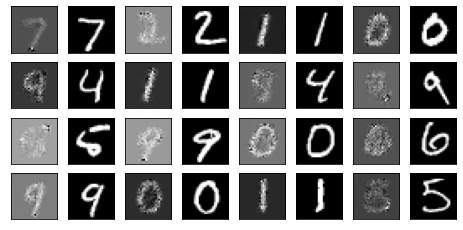

In [8]:
from src.utils.vae import generate_images
# no changes applied to variance during training
# images are reconstructed by sampling from the normal distribution with learned mean and std dev values. 
generate_images(eval_VAE_full_img, test)

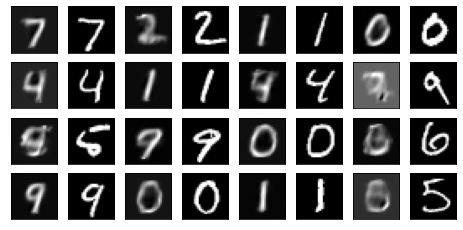

In [9]:
generate_images(eval_VAE_full_img, test)
# we ignored variance during reconstruction process, plotted just mean

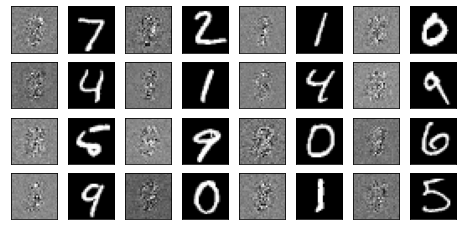

In [8]:
from src.utils.vae import generate_images
#foreground var multiplied by 0.5 and background var multiplied by 2 during training
generate_images(eval_VAE_full_img, test)

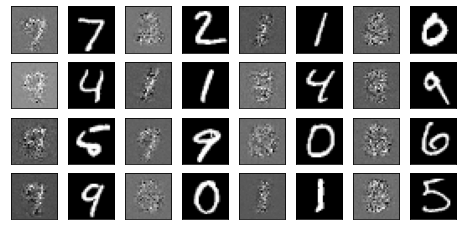

In [11]:
generate_images(eval_VAE_full_img, test)
#foreground var is preserved and background var multiplied by 2 during training